## Set the environment

We will first load the necessary python libraries.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
datafiles = 'gdrive/MyDrive/Integrated gradient/' # The folder where the code/datasets and example images are located.
print('data is in: ', datafiles)

Mounted at /content/gdrive
data is in:  gdrive/MyDrive/Integrated gradient/


In [2]:
# set-up environment
import numpy as np
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os  # necessary
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow   # specific for colab

import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

## 1. Load a pretrained CNN model.

We will make use of the VGG19 CNN network and ImageNet.

- ImageNet is a large collection of images.
- VGG19 is a convolutional neural network architecture.
- We load a version that is trained on ImageNet and that can detect objects in 1000 classes.

The first step is that using the pytorch library, we load the pretrained version of VGG19.

Since we will not train the model we set the model in evaluation mode.

In [3]:
# load model
# model_type = 'vgg19'
model = models.vgg19(pretrained=True)

# run it on a GPU if available:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('cuda:', cuda, 'device:', device)
model = model.to(device)

# set model to evaluation
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.2MB/s]


cuda: True device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 2. Load and preprocess the images

Load an image.

VGG-19 works best if image is normalised. Image should also be in the correct tensor format.

--> ensure that input is in correct tensor format. Tip: you can use pytorch method like:

input = torch.tensor(input, dtype=torch.float32, device=torch_device).

In [4]:
cd /content/gdrive/My Drive/IG/images/

/content/gdrive/My Drive/IG/images


In [5]:
def pre_processing(obs, cuda):
    # Students should transpose the image to the correct tensor format.
    # Students should ensure that gradient for input is calculated
    # set the GPU device
    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')

    # normalise
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std

    # make tensor format that keeps track of gradient
    # BEGIN for students to do
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device)
    # END for students to do
    return obs_tensor

# read the image and convert it
img = cv2.imread('caretta.jpg')

# img = cv2.imread(datafiles+ 'shark/Shark1.jpeg')
img = cv2.resize(img, (224, 224))
img = img.astype(np.float32)
img = img[:, :, (2, 1, 0)]
print('img:', img.shape)

img: (224, 224, 3)


## **3. Predict class**

We can now easily predict the class, and the softmax score of that prediction.

In [6]:
def predict(input, model, target_label_idx, cuda):
    # Student should make prediction after preprocessing image
    # Student should use softmax for getting predicion < 1.
    # Note that output should be torch.tensor on cuda

    output = model(input)
    output = F.softmax(output, dim=1)            # calc output from model

    if target_label_idx is None:
      target_label_idx = torch.argmax(output, 1).item()
    index = np.ones((output.size()[0], 1)) * target_label_idx
    index = torch.tensor(index, dtype=torch.int64)
    if cuda:
      index = index.cuda()                     # calc prediction
    output = output.gather(1, index)           # gather functionality of pytorch
    return target_label_idx, output

# test preprocessing
input = pre_processing(img, cuda)          # preprocess: image (normalise, transpose, make tensor on cuda, requires_grad=True)
output = predict(input, model, None, cuda)
print('output:', output)

output: (33, tensor([[0.7080]], device='cuda:0', grad_fn=<GatherBackward0>))


# 4. Visualizing Gradients

In [7]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=False):
    # Students have to calculate the gradient of the output w.r.t. the input image
    # The result should be a gradients numpy matrix of same dimensions as the inputs
    predict_idx = None
    gradients = []
    for input in inputs:# for every image

        input = pre_processing(input, cuda)
        input.requires_grad=True
        _, output = predict(input, model, target_label_idx, cuda)
        model.zero_grad()

        # BEGIN students TODO
        # Add the missing code for the backprop
        output.backward()
        # END students TODO

        gradient = input.grad.detach().cpu().numpy()[0]  # do backward and gather gradients of input
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

# calculate the gradient and the label index
gradients, label_index = calculate_outputs_and_gradients([img], model, None, cuda)
gradients = np.transpose(gradients[0], (1, 2, 0))

print('gradients', gradients.shape)
print(gradients[:3, :3, 0])

gradients (224, 224, 3)
[[ 3.0616214e-03  5.9076585e-04  8.1441732e-04]
 [-1.3590944e-03 -3.9552189e-03 -1.5768881e-03]
 [-3.6562481e-03  7.4714801e-05 -1.6065333e-03]]


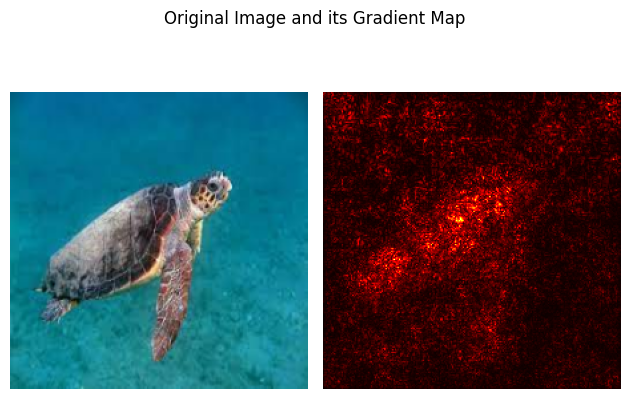

In [8]:
# Retrieve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=2. Recall the shape of gradients (width, height, channel)

def plot_gradients(img, gradients, title):
  # plots image (dimensions: Width X Heigth X 3) and gradients (dimensions: Width X Heigh x 3) - both numpy arrays
  saliency = np.max(np.abs(gradients), axis=2)       # takes maximum over 3 color channels
  # Visualize the image and the saliency map
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img/255)
  ax[0].axis('off')
  ax[1].imshow(saliency, cmap='hot')
  ax[1].axis('off')
  plt.tight_layout()
  fig.suptitle(title)
  plt.show()

plot_gradients(img, gradients, 'Original Image and its Gradient Map')

In [9]:
# integrated gradients
def integrated_gradients(inputs, model, target_label_idx, baseline, steps=50, cuda=False):

    # determine baseline
    if baseline is None:
        baseline = 0 * inputs
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = calculate_outputs_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, cuda) - pre_processing(baseline, cuda)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

In [10]:
# blurred baseline
def generate_blurred_baseline(input_image, blur_kernel_size):
    blurred_image = cv2.GaussianBlur(input_image, (blur_kernel_size, blur_kernel_size), 0)
    return blurred_image

blur_kernel_size = 5  # Adjust the kernel size as desired

baseline_image = generate_blurred_baseline(img, blur_kernel_size)

int_gradients_blurred = integrated_gradients(img, model, label_index, baseline=baseline_image, steps=50, cuda=cuda)

In [11]:
# gray baseline
def generate_gray_baseline(image_shape, gray_value=128):
    baseline = np.ones(image_shape + (3,), dtype=np.uint8) * gray_value
    return baseline

gray_value = 128  # Adjust the gray value based on your preference

gray_baseline = generate_gray_baseline(img.shape[:2], gray_value)

int_gradients_gray = integrated_gradients(img, model, label_index, baseline=gray_baseline, steps=50, cuda=cuda)

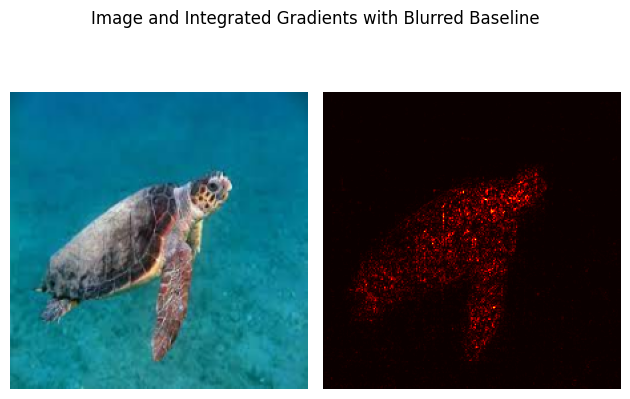

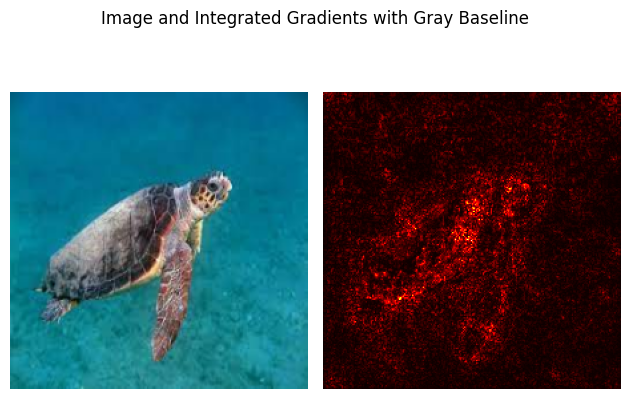

In [12]:
plot_gradients(img, int_gradients_blurred, 'Image and Integrated Gradients with Blurred Baseline')
plot_gradients(img, int_gradients_gray, 'Image and Integrated Gradients with Gray Baseline')

# 5. Generating superpixels

First we generate the superpixels using the quickshift function, but as imput we use the integrated gradients with blurry baseline instead of the original image.

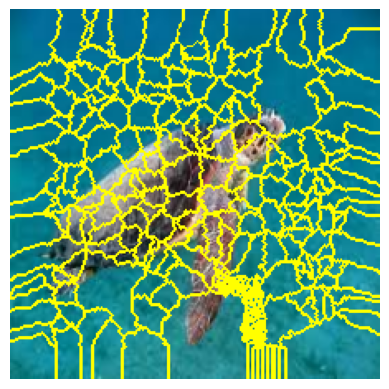

In [13]:
import skimage.segmentation

superpixels = skimage.segmentation.quickshift(int_gradients_blurred/255, kernel_size=6, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]

imgplot = plt.imshow(skimage.segmentation.mark_boundaries(img/255, superpixels))
plt.axis('off')
plt.show()

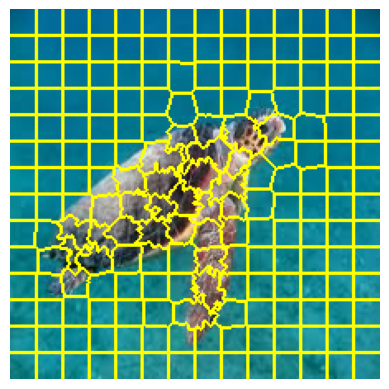

In [14]:
import skimage.segmentation

# Perform k-means clustering using SLIC
num_segments = 200
compactness = 4
segments = skimage.segmentation.slic(int_gradients_blurred/255, n_segments=num_segments, compactness=compactness, max_num_iter=10, sigma=1)

imgplot = plt.imshow(skimage.segmentation.mark_boundaries(img/255, segments))
plt.axis('off')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


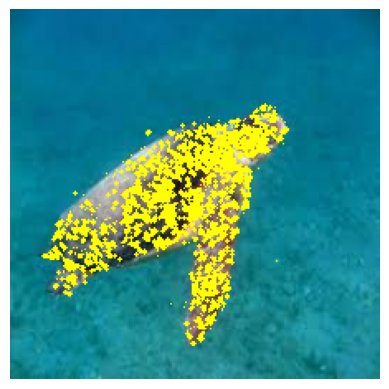

In [15]:
from sklearn.cluster import KMeans

# Reshape the integrated gradients array to match the expected input format for k-means clustering
int_gradients_flattened = int_gradients_blurred.reshape(-1, 3)

# Apply k-means clustering
num_clusters = 3  # Adjust the number of clusters as desired
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
labels = kmeans.fit_predict(int_gradients_flattened)

# Reshape the labels array to match the shape of the original image
labels = labels.reshape(int_gradients_blurred.shape[:2])

# Plot the image with cluster boundaries
imgplot = plt.imshow(skimage.segmentation.mark_boundaries(img/255, labels))
plt.axis('off')
plt.show()

In [28]:
num_perturb = 1500
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_segments))


In [29]:
size_of_perturbations = perturbations.shape

print(size_of_perturbations)

(1500, 200)


In [30]:
def perturb_image(gradients, perturbation, segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  mask[np.isin(segments, active_pixels)] = 1

  perturbed_gradients = gradients * mask[:, :, np.newaxis]

  return perturbed_gradients


In [31]:
perturbed_gradients = perturb_image(int_gradients_blurred, perturbations[0], segments)


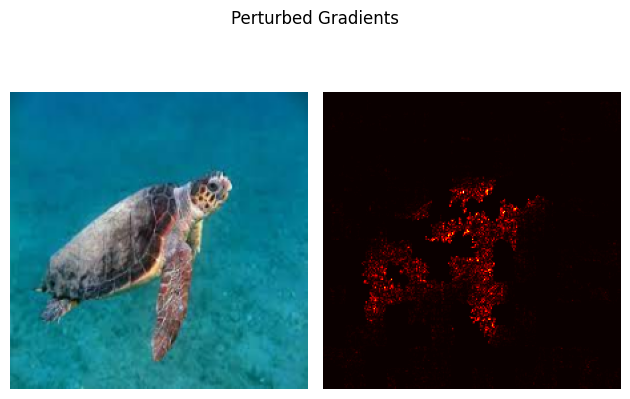

In [32]:
plot_gradients(img, perturbed_gradients, 'Perturbed Gradients')

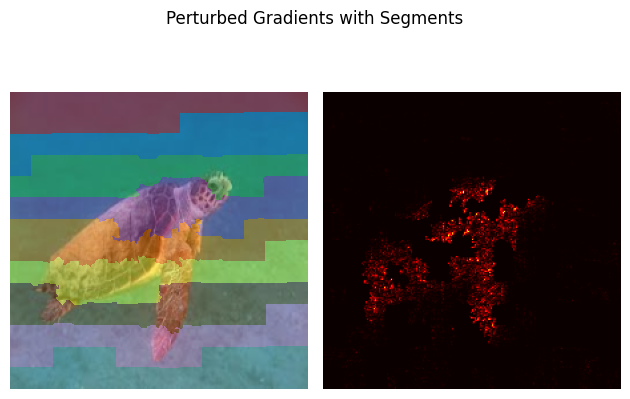

In [33]:
def plot_gradients_with_superpixels(img, gradients, superpixels, title):
    saliency = np.max(np.abs(gradients), axis=2)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img/255)
    ax[0].imshow(superpixels, alpha=0.5, cmap='Set1')
    ax[0].axis('off')
    ax[1].imshow(saliency, cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle(title)
    plt.show()

plot_gradients_with_superpixels(img, perturbed_gradients, segments, 'Perturbed Gradients with Segments')


# 6. Classification

In [34]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(img,pert,superpixels)
  input_ = pre_processing(perturbed_img, cuda)
  output, label = predict(input_, model, None, cuda)

  output = model(input_)
  output = F.softmax(output, dim=1)
  print (output.shape)
  target_label_idx = torch.argmax(output, 1).item()

  predictions.append(output.detach().cpu().numpy())

predictions = np.array(predictions)
predictions.shape

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size

(1500, 1, 1000)

In [35]:
# Calculate distances

original_image = np.ones(num_segments)[np.newaxis,:] #Perturbation with all superpixels enabled

print(original_image)
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]]


(1500,)

In [36]:
# Apply kernels

kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function, this is the author implementation and slightly different than the one in the paper
weights.shape

(1500,)

In [37]:
# Check top 5 predictions

out = model(input_)
print (out.shape)
out = F.softmax(out, dim=1)

out, indices= torch.sort(out, descending=True)

top_values = out[:, :5] # Keep the first 5 values from each row
top_indices = indices[:, :5]   # Keep the corresponding indices

top5 = torch.topk(out, k=5)

topk_values = top_values.detach().cpu().numpy()
topk_indices =  top_indices.detach().cpu().numpy()

print(topk_values)
print(topk_indices)

torch.Size([1, 1000])
[[0.7821763  0.03882723 0.03641732 0.02132635 0.02028921]]
[[973 396 107 988   4]]


In [38]:
simpler_model = LinearRegression()

# BEGIN YOUR CODE
# add the parameters for the linear model simple_model.fit()
simpler_model.fit(perturbations, np.argmax(predictions, axis=-1), sample_weight=weights)

#END YOUR CODE

coeff = simpler_model.coef_[0]
coeff

array([ 7.01771188e+00, -1.01430269e+00,  3.97857566e+00, -2.94549798e+01,
        1.53824621e+01, -1.41751872e+01, -1.30434691e+01, -2.92867602e+01,
       -1.83346755e+00,  1.04840896e+01, -3.79657464e+00, -7.03278735e+00,
        3.65629541e+01,  1.38497790e+00,  5.49790366e+00,  8.45424452e+00,
       -2.29183596e+01,  5.41330371e+00,  1.31619612e+01, -2.21069253e+01,
        1.16620176e+01,  1.62883262e+01,  7.69699874e+00,  3.26324452e+01,
       -4.54673509e+00,  5.41062277e+00,  1.40288916e+01, -2.30008548e+01,
        4.40061350e+00, -1.29236142e+01,  1.74134447e+01,  1.46424243e+00,
        1.10955931e+01, -3.29273418e+00,  1.80631576e+01, -3.30624120e+00,
       -2.46621164e+01, -1.02195910e+01, -1.08420691e+00, -6.07545930e+00,
       -8.31246761e+00, -1.62051472e+01,  2.26613808e+00,  2.33255955e+00,
       -1.05066132e+01, -3.42491769e+00,  1.62789624e+01,  1.94966013e+01,
        1.91758319e+00,  1.62622407e+01,  9.15053710e+00, -6.40112468e+00,
        1.22620450e+01,  

In [39]:
num_top_features = 2
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([23, 12])

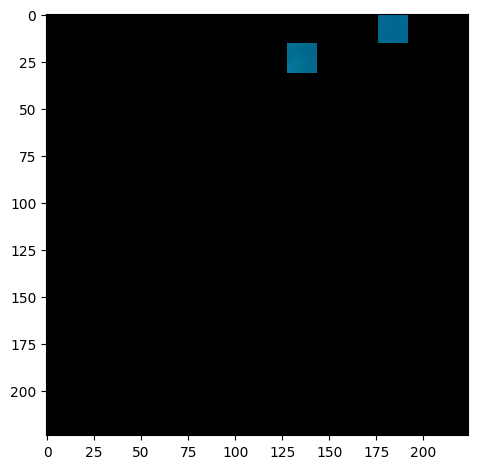

In [40]:
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img/255,mask,segments) )